# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc(Accuracy)를 보인 시도를 명시해주세요!


In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [2]:
from sklearn.datasets import load_wine
# 데이터셋 종류 :
data = load_wine()

In [3]:
input = data.data
output = data.target

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True) #stratify는 클래스의 분포를 유지, 모델이 특정 클래스에 편향되지 않도록 도움

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long(정수형 레이블) 에 옮겨놓는가? -> loss function이 다르기 때문 (Neural network의 loss function은 주로 정수형 레이블을 입력으로 받아 계산)

In [32]:
print(x_train[0])
print(y_train)

# input 13개 (속성이 13개)
# ylabel은 3개

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 2, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2,
        0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 1, 1, 2,
        0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0,
        0, 2, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 0, 2,
        1, 2, 2, 1], device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self, x_train, y_train, device): # device는 cpu 차원을 cuda 차원으로 넘겨주는 역할을 함
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
    self.device = device
    # 데이터셋의 전처리를 해주는 부분
    # 여기에서는 간단한 스케일링을 예시로 추가
    self.x_data = self.preprocessing(self.x_data)

  def preprocessing(self, data):
        # 간단한 Min-Max 스케일링을 예시로 추가
        min_val = min(map(min, data))
        max_val = max(map(max, data))
        scaled_data = [[(val - min_val) / (max_val - min_val) for val in row] for row in data]
        return scaled_data

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # idx(인덱스)에 해당하는 샘플 반환
    x = torch.FloatTensor(self.x_data[idx]).to(self.device) # Tensor를 cuda차원으로 보내줌
    y = torch.LongTensor(self.y_data[idx]).to(self.device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [8]:
# 해당 부분 아래서 사용 X 왜 쓴 건지 잘 모르겠음.

batch_size = 8

dataset = CustomDataset(x_train, y_train, device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기


model = nn.Sequential(
          nn.Linear(13,398, bias=True), #첫번재 Hidden layer의 노드수는 398개
          nn.ReLU(),
          nn.Linear(398,15, bias=True), #두번재 Hidden layer의 노드수는 15개
          nn.ReLU(),
          nn.Linear(15,3, bias=True), #세번재 Hidden layer의 노드수는 3개 -> y의 Label 3개이기 때문
          nn.Softmax(dim=1) # 두개의 node 중 더 확률이 높은 값을 사용하려고 Softmax 사용
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [10]:
class Model(torch.nn.Module):

  def __init__(self, input_size):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(input_size,398, bias=True), # input_layer = 13, hidden_layer1 = 398
          nn.ReLU(), # sigmoid() 대신 ReLU() 사용 -> sigmoid()의 기울기에 대한 단점 보완, 계산 복잡도 낮아 효율성 증가
        nn.BatchNorm1d(398)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x): # 순전파 정의 함수
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [11]:
def init_weights(layer): # nerual network의 weight 초기화
    if isinstance(layer, nn.Linear): # 주어진 layer가 선형인지 확인
        torch.nn.init.xavier_uniform(layer.weight) # Xavier 초기화를 적용하여 가중치를 균등하게 초기화 -> 안정성 향상
        layer.bias.data.fill_(0.01) #bias를 0.01로 초기화

        #xavier사용 -> 가중치를 특정한 분포(균등 분포 또는 정규 분포)에서 뽑아낸 값으로 초기화
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [12]:
input_size = len(x_train[0])  # x_train의 첫 번째 샘플의 특성 수
model = Model(input_size).to(device)
model.apply(init_weights)

<ipython-input-11-1376bb522da5>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight) # Xavier 초기화를 적용하여 가중치를 균등하게 초기화 -> 안정성 향상


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [13]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)


In [14]:
loss_fn  = nn.CrossEntropyLoss().to(device) # 2개 이상의 label에 대해 classification의 측면에 사용되기 때문에 CrossEntropyLoss() 사용하는 것이 유리함
# 만약 1개 label에 대한 경우는 MSE, MAE 등 사용

# 여러가지 optimizer 시도해보기
# lr 바꿔보기 -> 모든 optimizer에 대해 learning rate 계속 변경 결과 0.01이 가장 좋은 결과를 보임


optimizer = optim.Adagrad(model.parameters(), lr= 0.01) # 가장 좋은 결과를 보인 optimizer -> 이유는? 아마도 batch size를 적용하지 않았기 때문으로 보임.

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adamax(model.parameters(), lr= 0.01)
#optimizer = optim.Adam(model.parameters(), lr= 0.01)
#optimizer = optim.AdamW(model.parameters(), lr= 0.01)
#optimizer = optim.NAdam(model.parameters(), lr= 0.01)

# sgd 등등

In [15]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model.forward(x_train) # 반복 실행 시 CUDA 관련 문제 발생 -> 아래쪽 참고

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item()) # 그래프 그리기 위해 Loss값을 losses라는 리스트에 추가, item()은 텐서에서 loss 결과값의 scaler만 추출하는 함수

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.0395019054412842
10 0.7279837727546692
20 0.6512361764907837
30 0.6090585589408875
40 0.5944061875343323
50 0.5824767351150513
60 0.5831121206283569
70 0.5705000758171082
80 0.5632441639900208
90 0.5571518540382385


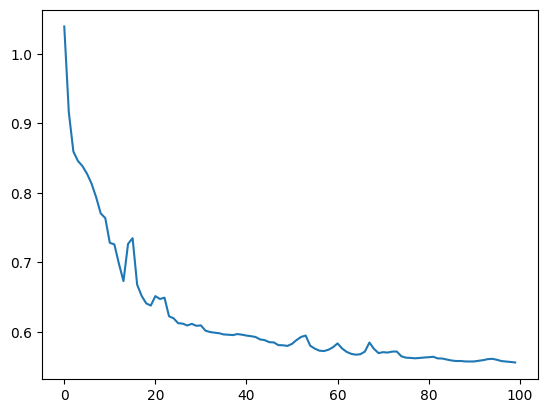

In [16]:
plt.plot(losses)
plt.show()

In [17]:
with torch.no_grad():
  model = model.to(device) # 기존의 코드는 model이 numpy 이용을 위해 cpu로 전환되기 때문에 다른 optimizer 사용을 위한 코드 재시작 시 오류가 있었음.
  y_pred = model(x_test.to(device)) # x_test도 cuda에 위치하도록 변경
  y_pred = y_pred.detach().cpu().numpy()  # GPU 사용을 위해 cpu().numpy()로 변경, detach는 gradient 빼서 메모리를 아끼는 역할을 함.
  predicted = np.argmax(y_pred, axis =1) # 가장 높은 확률의 y_pred index를 predicted에 저장
  accuracy = (accuracy_score(predicted, y_test))

In [18]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9987888e-01 9.7835175e-05 2.3262150e-05]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


# < 3주차 과제 2 : CNN 맛보기>
- FNN은 데이터가 많이 필요하다는 단점과 패턴 인식이 어렵다는 단점들이 존재
- But, CNN은 FNN에 비해 더 적은 parameter를 가짐 -> 더 많은 dataset이 강요되지 않음
- kernel을 사용하기에 기존 패턴 인식 단점 극복

In [19]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [20]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 74574062.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108156869.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50512667.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1541055.55it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# CNN 공부 시 Convolution(패턴 인식) -> Pooling(사이즈 줄임)-> Activation(비선형성 부여) -> Batch_normalization(분포 정렬) 순서로 주로 사용.

In [21]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # image 파일이기 때문에 convolution을 2차원으로 설정, 흑백 이미지이기에 input_size = 1, output_size가 커질수록 parameter가 많이 필요하나 패턴을 더 다양하게 인식 가능
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # Padding 값이 0임 -> convolution 계산 시 kernel이 input을 벗어나면 안됨.
    self.mp = nn.MaxPool2d(2) # output 에서 가장 큰 값 하나를 return하며 size를 줄임
    self.fc = nn.Linear(320, 10) ### : 알맞는 input은 -> conv2를 거친 후의 feature map 크기여야함. 따라서 20*4*4 (아래 feature map 크기 구하는 방법 참조)

  def forward(self, x):
    in_size = x.size(0) # 28*28
    x = F.relu(self.mp(self.conv1(x))) # -> feature map size가 kernel_size가 5이기에 24*24로 변환, mp로 인해 12*12로 반환
    x = F.relu(self.mp(self.conv2(x))) # -> feature map size가 kernel_size가 5이기에 8*8로 변환, mp로 인해 4*4로 반환 즉, [64, 20, 4, 4] 형태의 그림으로 존재함.
    x = x.view(in_size, -1) # -> batch를 제외한 남은 차원을 하나로 합침. 즉, [64, 320] 형태로 변환
    x = self.fc(x)
    return F.log_softmax(x) # -> 10개의 output을 softmax 처리해서 log로 반환

In [22]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

In [23]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target) # tensor에서 variable로 변환
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target) # 모델의 출력에 소프트 맥스를 적용해 로그로 변환(forward에서 return형태와 동일) 이후 CrossEntropyLoss 적용 -> 다중 클래스 분류 문제에 사용되는 손실 함수들 중 하나
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [24]:
def test():
    model.eval() #model.eval() 의 기능은?
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [25]:
for epoch in range(1, 10):
    train(epoch)
    test()

<ipython-input-21-4820c0182e17>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # -> 10개의 output을 softmax 처리해서 log로 반환


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333787
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.310540
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.303401
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.287821
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.272456
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.252066
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.247658
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.187569
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.163913
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.149293
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.066093
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.952025
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.835536
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.660598
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.417570
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.141111
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.011117
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.854689
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.832860
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.572486
Train Epoch: 1 [12800/60000 (

<ipython-input-24-f52337105c2a>:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1904, Accuracy: 9445/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.144356
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.311371
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.255028
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.413055
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.196605
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.076946
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.178278
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.220730
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.303001
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.197868
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.430021
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.187761
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.238727
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.208112
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.139427
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.139031
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.285748
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.137164
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.213065
Train Epoch: 2 [12